# Time series

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

/data/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
CYCLE_HIRES_URL = 'https://files.datapress.com/london/dataset/number-bicycle-hires/2017-11-06T09:27:35.00/tfl-daily-cycle-hires.xls'

Load TfL Cycle Hire dataset.

In [3]:
hires = pd.read_excel(CYCLE_HIRES_URL, sheet_name='Data')

Convert `Day` to `datetime` and set as index.

In [4]:
hires['Day'] = pd.to_datetime(hires['Day'], unit='D')
hires.set_index('Day', inplace=True)

Extract first column (daily hires) and convert to `float`.

In [5]:
hires = hires.iloc[:, 0].astype(float)

Plot time series.

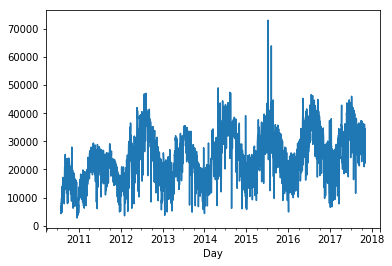

In [6]:
hires.plot()

## Aggregation

Resample at monthly resolution.

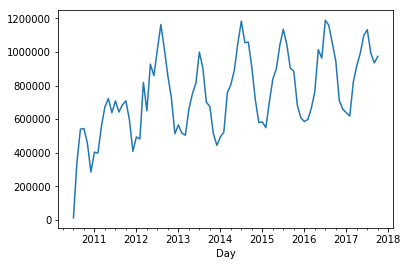

In [7]:
monthly_hires = hires.resample('M').sum()
monthly_hires.plot()

Box plots of daily hires by year, month, and weekday:

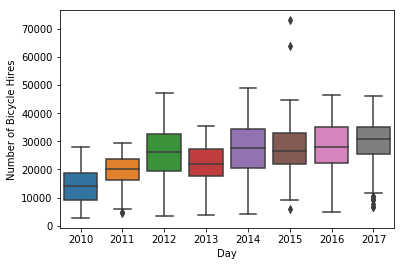

In [8]:
sns.boxplot(x=hires.index.year, y=hires)

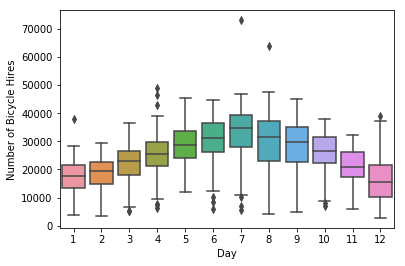

In [9]:
sns.boxplot(x=hires.index.month, y=hires)

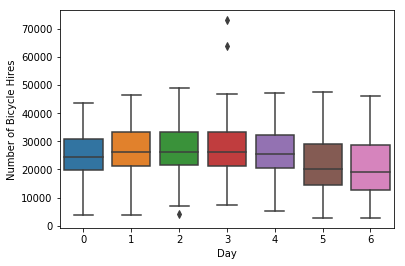

In [10]:
sns.boxplot(x=hires.index.weekday, y=hires)

## Rolling and exponentially weighted averages

### Rolling average

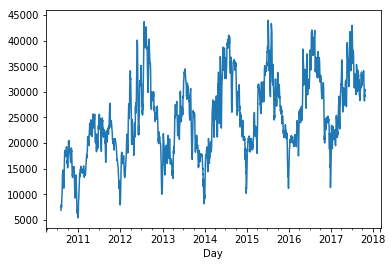

In [11]:
hires.rolling(window=7, center=True).mean().plot()

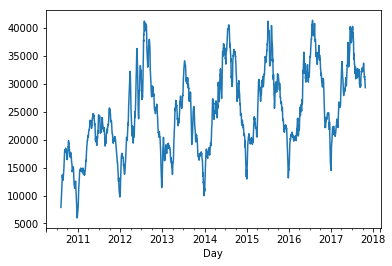

In [12]:
hires.rolling(window=14, center=True).mean().plot()

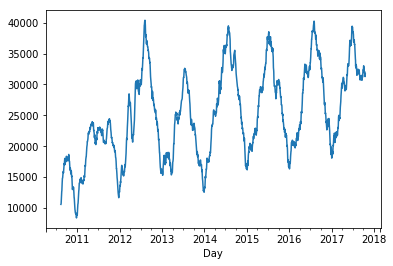

In [13]:
hires.rolling(window=30, center=True).mean().plot()

### Exponentially weighted moving average

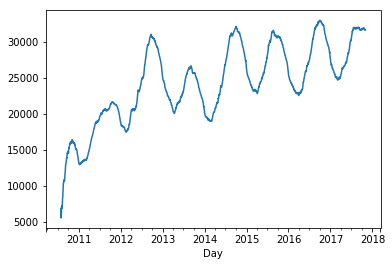

In [14]:
hires.ewm(alpha=0.01).mean().plot()

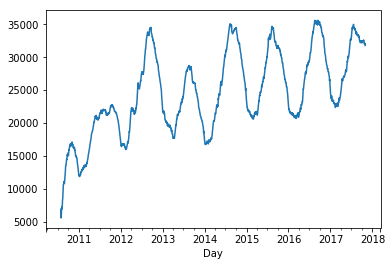

In [15]:
hires.ewm(alpha=0.02).mean().plot()

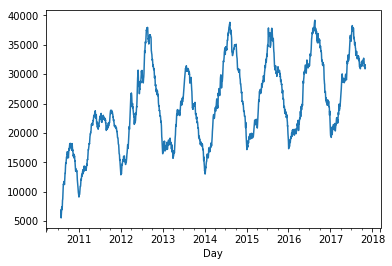

In [16]:
hires.ewm(alpha=0.05).mean().plot()

### Expanding average

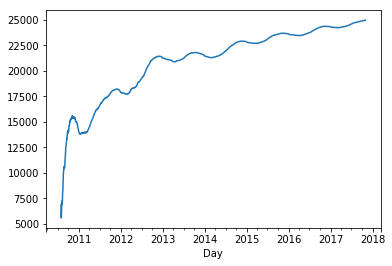

In [17]:
hires.expanding().mean().plot()

## Autocorrelation and stationarity

### Autocorrelation function (ACF)

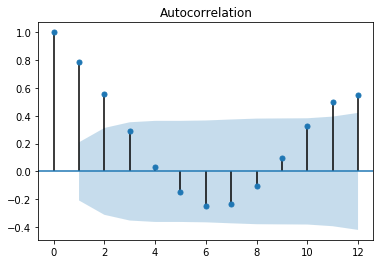

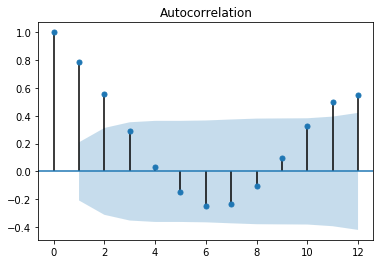

In [18]:
plot_acf(monthly_hires, lags=12)

### Partial autocorrelation function (PACF)

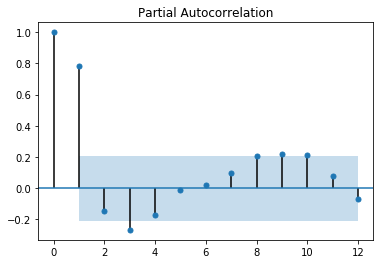

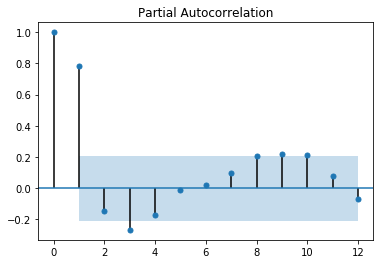

In [19]:
plot_pacf(monthly_hires, lags=12)

### Rolling statistics

In [20]:
def plot_rolling_statistics(ts):
    rolling_stats = ts.rolling(window=3).agg(['mean', 'std'])
    plt.plot(ts, color='gray', label='Original')
    plt.plot(rolling_stats['mean'], color='red', label='Rolling mean')
    plt.plot(rolling_stats['std'], color='blue', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.show(block=False)

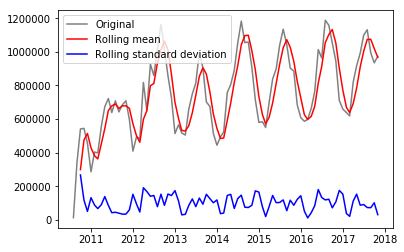

In [21]:
plot_rolling_statistics(monthly_hires)

### Augmented Dickey-Fuller test

*Note*: small $p$-values suggest stationarity.

In [22]:
sm.tsa.adfuller(hires)

(-3.1540040115674199,
 0.022806315580433383,
 27,
 2623,
 {'1%': -3.432845505561489,
  '10%': -2.5673569122802786,
  '5%': -2.8626425238283999},
 51897.283736620266)

### First-order differencing to induce stationarity

In [23]:
monthly_hires_diff = monthly_hires.diff(1).dropna()

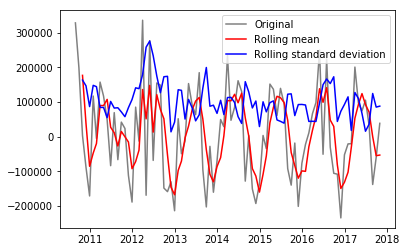

In [24]:
plot_rolling_statistics(monthly_hires_diff)

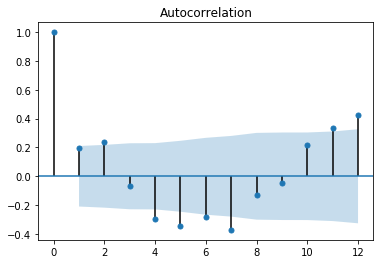

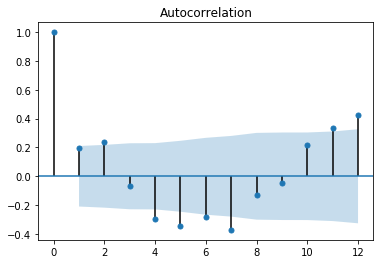

In [25]:
plot_acf(monthly_hires_diff, lags=12)

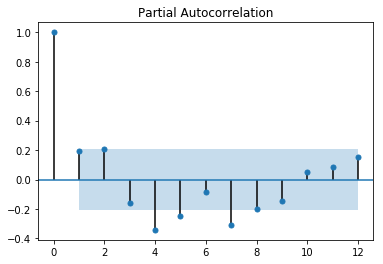

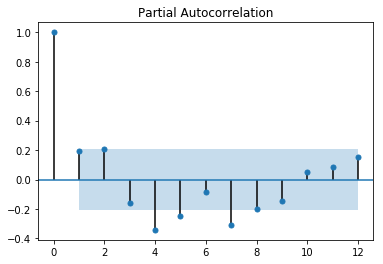

In [26]:
plot_pacf(monthly_hires_diff, lags=12)

In [27]:
sm.tsa.adfuller(monthly_hires_diff)

(-7.5262271860633936,
 3.678672397604037e-11,
 8,
 78,
 {'1%': -3.5171136048315041,
  '10%': -2.5869547797501644,
  '5%': -2.8993754262546574},
 1911.5489540388808)

## AR(I)MA modelling

*Hint*: check [this page](http://people.duke.edu/~rnau/arimrule.htm) for rules of thumb on choosing the order of differencing, as well as the number of AR and MA terms.

In [28]:
model = sm.tsa.ARIMA(monthly_hires, (1, 1, 1)).fit()

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.Number of Bicycle Hires   No. Observations:                   87
Model:                        ARIMA(1, 1, 1)   Log Likelihood               -1146.378
Method:                              css-mle   S.D. of innovations         127702.944
Date:                       Sun, 03 Dec 2017   AIC                           2300.756
Time:                               13:45:48   BIC                           2310.620
Sample:                           08-31-2010   HQIC                          2304.728
                                - 10-31-2017                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.105e+04   1.92e+04      0.577      0.566   -2.65e+04    4.86e+04
ar.L1.D.Number of Bicycle Hires     0.4650      0.200      2.323      0.023       0.073       0.857
ma.L1.D.Number of Bicycle Hires    -0.2469      0.196     -1.263      0.210      -0.630       0.136
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1504           +0.0000j            2.1504            0.0000
MA.1            4.0503           +0.0000j            4.0503            0.0000
-----------------------------------------------------------------------------
"""

Check ACF and PACF of residuals:

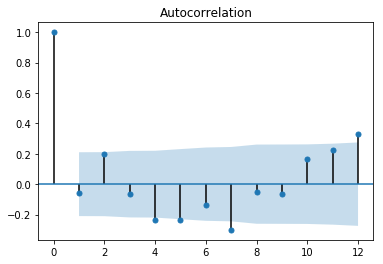

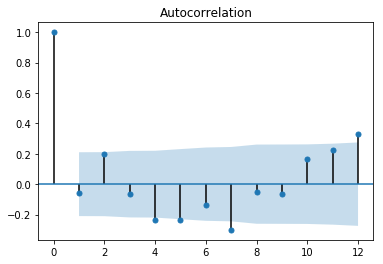

In [30]:
plot_acf(model.resid, lags=12)

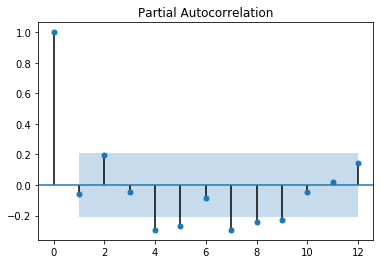

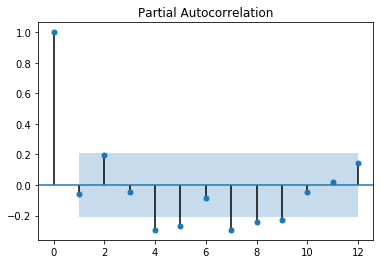

In [31]:
plot_pacf(model.resid, lags=12)

Plot predictions:

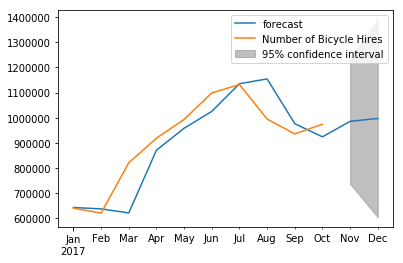

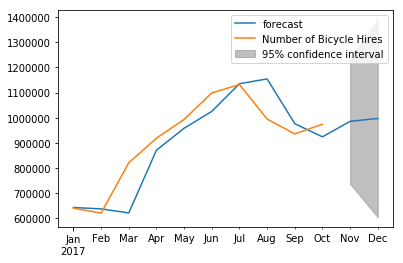

In [32]:
model.plot_predict('2017-01-31', '2017-12-31')